# Segmentation and Clustering Neighborhoods in Toronto,Canada

### Importing relevant libraries

In [1]:
#importing pandas and numpy libraries
import pandas as pd
import numpy as np

### Assigning the Wikipedia link to the object url

In [2]:
#assigning Wikipedia link to url
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

### Removing the row from the dataframe which have Borough names as 'Not Assigned

In [3]:
#dropping the rows having the Brough as 'Not assigned'
neigh_df=pd.read_html(url)[0]
neigh_df=neigh_df[neigh_df['Borough']!='Not assigned'].reset_index(drop=True)
neigh_df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### For the rows having the Neighbourhood names as 'Not assigned', replacing it with the Borough name

In [4]:
#replace with Borugh name for rows with Neighbourhood as 'Not assigned'
neigh_df['Neighbourhood'].replace('Not assigned',neigh_df['Borough'],inplace=True)

### Printing the number of rows in the data frame

In [5]:
print('Number of rows in the data frame :',neigh_df.shape[0])

Number of rows in the data frame : 103


### Importing geocoder library

In [6]:
!pip install geopy
from geopy.geocoders import Nominatim

### Creating empty columns for latitude and longitude

In [7]:
neigh_df['latitude']=''
neigh_df['longitude']=''
neigh_df.head()

,Postal Code,Borough,Neighbourhood,latitude,longitude
0,M3A,North York,Parkwoods,,
1,M4A,North York,Victoria Village,,
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",,
3,M6A,North York,"Lawrence Manor, Lawrence Heights",,
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",,


### Importing the latitude and longitude data from 'Geospatial_Coordinates.csv'

In [8]:
lat_lng_df = pd.read_csv('Geospatial_Coordinates.csv')
lat_lng_df.head()


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Copying the latitude and longitude values from lat_lng_df to neigh_df

In [9]:
for i in neigh_df.index:
    neigh_df.at[i,'latitude']=lat_lng_df[lat_lng_df['Postal Code']==neigh_df.at[i,'Postal Code']]['Latitude'].values[0]
    neigh_df.at[i,'longitude']=lat_lng_df[lat_lng_df['Postal Code']==neigh_df.at[i,'Postal Code']]['Longitude'].values[0]
neigh_df.head(5)

,Postal Code,Borough,Neighbourhood,latitude,longitude
0,M3A,North York,Parkwoods,43.7533,-79.3297
1,M4A,North York,Victoria Village,43.7259,-79.3156
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6543,-79.3606
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7185,-79.4648
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6623,-79.3895


### Importing all the required libraries

In [10]:
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!pip install folium==0.5.0
import folium # map rendering library

### Taking the neighbourhoods located in Downtown Toronto,East Toronto, West Toronto, Central Toronto

In [11]:
toronto_df=neigh_df[neigh_df['Borough'].str.contains(r'Toronto')].reset_index(drop=True)
toronto_df.head()

,Postal Code,Borough,Neighbourhood,latitude,longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6543,-79.3606
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6623,-79.3895
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3789
3,M5C,Downtown Toronto,St. James Town,43.6515,-79.3754
4,M4E,East Toronto,The Beaches,43.6764,-79.293


Obtaining latitude and longititude of Toronto

In [12]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 43.6534817, -79.3839347.


### Defining functiions to gather the nearby venues in each neighbourhood

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Defining functions to extract the category of the venue

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


### Credentials to access data from Foursquare.com

In [15]:
CLIENT_ID = '2GDAGZHGUBS1QCAAZBRC3X1SZ2UAAKCRK04OKSLDLWJHEHXN' # your Foursquare ID
CLIENT_SECRET = '2LG1Q14H0JHLQBNJA0VMXXHOTXC2OVKDJDOFW53ACPM4FNPI' # your Foursquare Secret
VERSION = '20201108'
LIMIT = 100

### Gathering the list of near by venues in Downtown Toronto,East Toronto, West Toronto, Central Toronto

In [16]:
toronto_venues=getNearbyVenues(names=toronto_df['Neighbourhood'],
                                latitudes=toronto_df['latitude'],
                                longitudes=toronto_df['longitude'])

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

In [17]:
toronto_venues.shape

(1624, 7)

In [18]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [19]:
toronto_df['Borough'].unique()

array(['Downtown Toronto', 'East Toronto', 'West Toronto',
       'Central Toronto'], dtype=object)

Checking how many venues are returned for each neighbourhood

In [20]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,55,55,55,55,55,55
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,68,68,68,68,68,68
Christie,16,16,16,16,16,16
Church and Wellesley,75,75,75,75,75,75
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,33,33,33,33,33,33


Finding out how many unique categories can be curated from all the returned venues

In [21]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 236 uniques categories.


### Analysing Each Neighborhood

In [22]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Getting the size of the dataframe

In [23]:
toronto_onehot.shape

(1624, 236)

Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [24]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,Berczy Park,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.018182,0.000000,0.000000,0.000000,0.00
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
2,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.0625,0.0625,0.0625,0.125,0.125,0.0625,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
4,Central Bay Street,0.014706,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.014706,0.000000,0.000000,0.014706,0.00
5,Christie,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
6,Church and Wellesley,0.026667,0.013333,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.013333,...,0.013333,0.013333,0.000000,0.000000,0.00,0.000000,0.000000,0.013333,0.000000,0.00
7,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.040000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.00
8,Davisville,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.030303,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
9,Davisville North,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00


The size of the dataframe toronto_grouped

In [25]:
toronto_grouped.shape

(39, 236)

Printing each neighborhood along with the top 5 most common venues

In [26]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1  Seafood Restaurant  0.04
2         Cheese Shop  0.04
3            Beer Bar  0.04
4        Cocktail Bar  0.04


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.13
1       Nightclub  0.09
2     Coffee Shop  0.09
3  Breakfast Spot  0.09
4   Grocery Store  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0  Fast Food Restaurant  0.06
1         Auto Workshop  0.06
2            Comic Shop  0.06
3           Pizza Place  0.06
4      Recording Studio  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
             venue  freq
0   Airport Lounge  0.12
1  Airport Service  0.12
2  Harbor / Marina  0.06
3            Plane  0.06
4    Boat or Ferry  0.06


----Central Bay Street----
                venue  freq
0         Coff

Function to sort venues in descending order

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a new dataframe to display top 10 veneus in each neighbourhood

In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Farmers Market,Bakery,Cocktail Bar,Seafood Restaurant,Cheese Shop,Beer Bar,Restaurant,Grocery Store,Pub
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Nightclub,Pet Store,Bar,Burrito Place,Restaurant,Climbing Gym,Performing Arts Venue
2,"Business reply mail Processing Centre, South C...",Skate Park,Pizza Place,Brewery,Burrito Place,Restaurant,Farmers Market,Fast Food Restaurant,Recording Studio,Butcher,Light Rail Station
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Coffee Shop,Harbor / Marina,Plane,Rental Car Location,Sculpture Garden,Boutique,Bar,Boat or Ferry
4,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Salad Place,Burger Joint,Department Store,Japanese Restaurant,Thai Restaurant,Bubble Tea Shop


## Clustering the Neighbourhoods

k-means algorithm to split the neighbourhoods into 5 clusters

In [29]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Create a new data frame to includes clusters labels and top 10 venues of each neighbourhood

In [30]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6543,-79.3606,0,Coffee Shop,Pub,Park,Bakery,Café,Theater,Breakfast Spot,Brewery,Spa,Beer Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6623,-79.3895,0,Coffee Shop,Yoga Studio,Hobby Shop,Restaurant,Sandwich Place,Distribution Center,Diner,Italian Restaurant,Beer Bar,Café
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3789,0,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Bubble Tea Shop,Cosmetics Shop,Middle Eastern Restaurant,Furniture / Home Store,Lingerie Store,Pizza Place
3,M5C,Downtown Toronto,St. James Town,43.6515,-79.3754,0,Coffee Shop,Café,Cocktail Bar,Restaurant,Gastropub,American Restaurant,Beer Bar,Clothing Store,Gym,Cosmetics Shop
4,M4E,East Toronto,The Beaches,43.6764,-79.293,0,Health Food Store,Pub,Trail,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Women's Store


### Visualizing the resultant clusters on the map

In [31]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['latitude'], toronto_merged['longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

In GitHub, the folium map is not showing up. So, in order to show the map, a screenshot of the map has to be taken as an image and the image has to be loaded into the notebook. The code in the below cell will perform this action

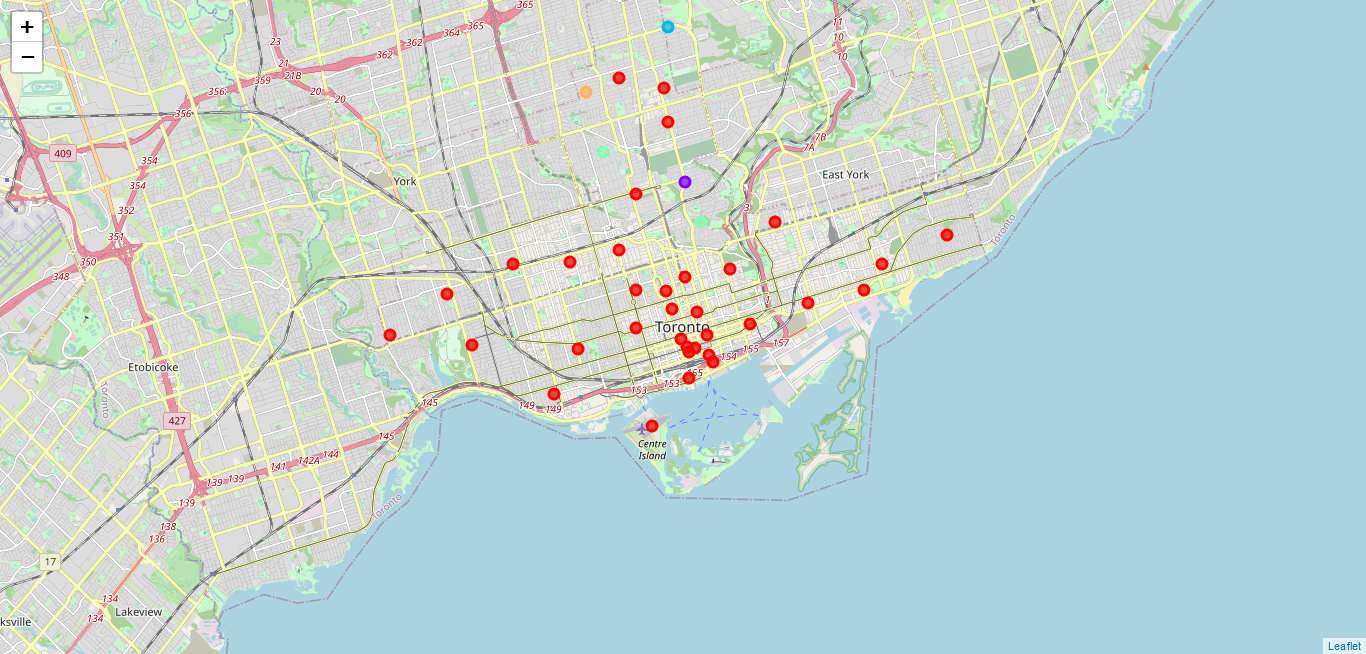

In [32]:
from selenium import webdriver
driver = webdriver.Firefox(executable_path=r'C:\Users\Administrator\Downloads\geckodriver.exe')
import os
import time
from IPython.display import Image
delay=5
fn='testmap.html'
tmpurl='file:///D:/Udemy/Time Series Analysis and Forecasting/Files/Files for Regression/testmap.html'
map_clusters.save(fn)
browser = webdriver.Firefox()
#..that displays the map...
browser.get(tmpurl)
#Give the map tiles some time to load
time.sleep(delay)
#Grab the screenshot
browser.save_screenshot('map.png')
#Close the browser
browser.quit()
Image(filename='map.png')

## Examining each cluster

### Cluster 1

In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,"Regent Park, Harbourfront",0,Coffee Shop,Pub,Park,Bakery,Café,Theater,Breakfast Spot,Brewery,Spa,Beer Store
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",0,Coffee Shop,Yoga Studio,Hobby Shop,Restaurant,Sandwich Place,Distribution Center,Diner,Italian Restaurant,Beer Bar,Café
2,Downtown Toronto,"Garden District, Ryerson",0,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Bubble Tea Shop,Cosmetics Shop,Middle Eastern Restaurant,Furniture / Home Store,Lingerie Store,Pizza Place
3,Downtown Toronto,St. James Town,0,Coffee Shop,Café,Cocktail Bar,Restaurant,Gastropub,American Restaurant,Beer Bar,Clothing Store,Gym,Cosmetics Shop
4,East Toronto,The Beaches,0,Health Food Store,Pub,Trail,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Women's Store
5,Downtown Toronto,Berczy Park,0,Coffee Shop,Farmers Market,Bakery,Cocktail Bar,Seafood Restaurant,Cheese Shop,Beer Bar,Restaurant,Grocery Store,Pub
6,Downtown Toronto,Central Bay Street,0,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Salad Place,Burger Joint,Department Store,Japanese Restaurant,Thai Restaurant,Bubble Tea Shop
7,Downtown Toronto,Christie,0,Grocery Store,Café,Park,Candy Store,Restaurant,Nightclub,Baby Store,Coffee Shop,Athletics & Sports,Italian Restaurant
8,Downtown Toronto,"Richmond, Adelaide, King",0,Coffee Shop,Café,Hotel,Restaurant,Gym,Bar,Clothing Store,Thai Restaurant,Concert Hall,Breakfast Spot
9,West Toronto,"Dufferin, Dovercourt Village",0,Pharmacy,Bakery,Grocery Store,Brewery,Bar,Bank,Café,Middle Eastern Restaurant,Supermarket,Park


### Cluster 2

In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Central Toronto,"Moore Park, Summerhill East",1,Trail,Playground,Women's Store,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


### Cluster 3

In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,Lawrence Park,2,Park,Bus Line,Swim School,College Rec Center,Department Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


### Cluster 4

In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",3,Park,Sushi Restaurant,Jewelry Store,Trail,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
33,Downtown Toronto,Rosedale,3,Park,Trail,Playground,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


### Cluster 5

In [37]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,Roselawn,4,Music Venue,Garden,Women's Store,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


### Observations
By viewing the top 10 venues for each cluster we can clearly see that
1. The neighbourhoods of Cluster-1 is mainly filled with restaurants, coffee shops.
2. In Cluster-2, there is only one neighbourhood Moore Park, Summerhill East and the most common veneu is the trail. It is clearly evident by looking at the map also.
3. Similar to cluster-2, cluster-3 is also having only one neighbourhood Lawrence Park. The most common venue is park. We can clearly see that in the map.
4. there are two neighbourhoods in cluster-4 with most common venues as park and trail.
5. Cluster-5 is having only one district with most common venue as Music Venue.